# The PolInSAR Course - May 13, 2024
# Differential Interferometric SAR (DInSAR) 

In this section we are working with data acquired by ESA's satellite ENVISAT, which was operative from 2002 until 2012. The data set was acquired before and after the Bam earthquake, which took place in Bam, Iran, on December 26, 2003. The following acquisitions are available:

- Primary acquisition acquired on December 3, 2003.
- Secondary 1 acquisition acquired on January 7, 2004.
- Secondary 2 acquisition acquired on February 11, 2004.

Objective: 
- Calculate DInSAR phase between primary and secondary images to show surface deformation due to the earthquake


Data:
- Path: 'data/DInSAR/'
- SLCs: primary_envisat.npy, secondary1_envisat.npy, secondary2_envisat.npy
- Flat-earth Phase: flat_earth1_envisat.npy, flat_earth2_envisat.npy
- DEM + flat-earth phase: dem_flat1_envisat.npy, dem_flat2_envisat.npy
- DEM: slantdem_envisat.npy
- Kz: kz1_envisat.npy, kz2_envisat.npy

Notes/Tips: 
- Each image has been filtered and decimated in both dimensions. After the filtering and decimation, the images have a resolution of 49.0 m and 42 m in ground range and azimuth, respectively.
- The secondary images are already coregistered to the primary geometry.
- Baseline between primary and secondary 1 acquisition: 520 m
- Baseline between primary and secondary 2 acquisition: 0.1 m 

In [1]:
# --- Download exercise data & import reader function
from pysarpro import io, data
from pysarpro.io import rrat

data_download_subfolder = "DInSAR"

data.download_all(directory="/projects", pattern=r'^data/DInSAR')


# --- Import useful libaries, functions, and modules
import sys
sys.path.append('/projects/src/')
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from numpy.fft import fft2, ifft2

%matplotlib widget

In [2]:
def calculate_covariance(im1, im2, looksr, looksa) : 
    
    corr = uniform_filter(np.real(im1*np.conj(im2)), [looksa,looksr]) + 1j* \
                uniform_filter(np.imag(im1*np.conj(im2)), [looksa,looksr])
    
    return corr


#---Function to smooth phase
def smooth(array, box, phase=False):
    """
    Performs a moving average operation with a boxcar window. Can also (correctly) smooth interferometric phases with the phase=True keyword.
    """
    if np.iscomplexobj(array):
        return uniform_filter(array.real, box) + 1j * uniform_filter(array.imag, box)
    elif phase is True:
        return np.angle(smooth(np.exp(1j * array), box))
    else:
        return uniform_filter(array.real, box) 

**Load and display data**

Text(0.5, 1.0, 'Amplitude Primary')

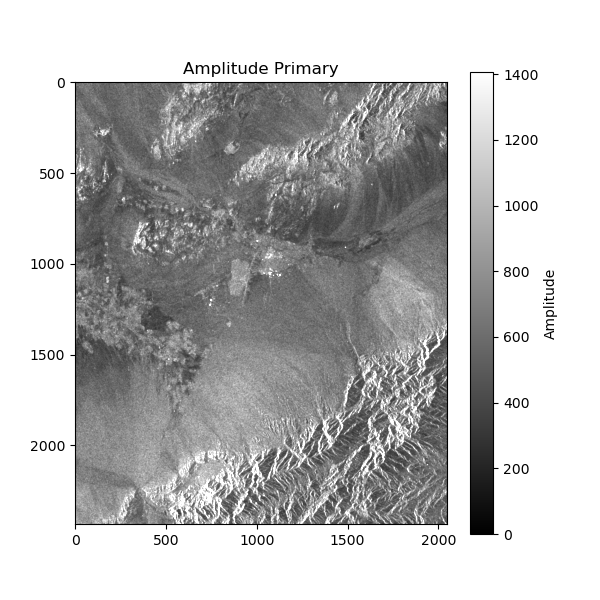

In [3]:
# Path
path = 'data/DInSAR/'

# Read primary image
img_p = np.load(path + 'primary_envisat.npy')

# Read secondary images
img_s1 = np.load(path + 'secondary1_envisat.npy')
img_s2 = np.load(path + 'secondary2_envisat.npy')

# Multilook window size
looksr = 5
looksa = 5


# Display
amp_p = np.sqrt(np.abs(calculate_covariance(img_p, img_p, looksr, looksa)))
plt.figure(figsize=(6,6))
plt.imshow(np.abs(amp_p), vmin=0, vmax=2*np.mean(amp_p), cmap='gray')
cb = plt.colorbar()
cb.set_label('Amplitude')
plt.title('Amplitude Primary')


**Flat Earth Compensation**

In [4]:
# Load the flat-earth phase term
flat_phase_s1 = np.load(path + 'flat_earth1_envisat.npy')
flat_phase_s2 = np.load(path + 'flat_earth2_envisat.npy')

# Compensate
img_s1_fe = img_s1 * np.exp(1j*flat_phase_s1)
img_s2_fe = img_s2 * np.exp(1j*flat_phase_s2)

**Coherence and Phase Estimation**

Text(0.5, 1.0, 'Phase PS2')

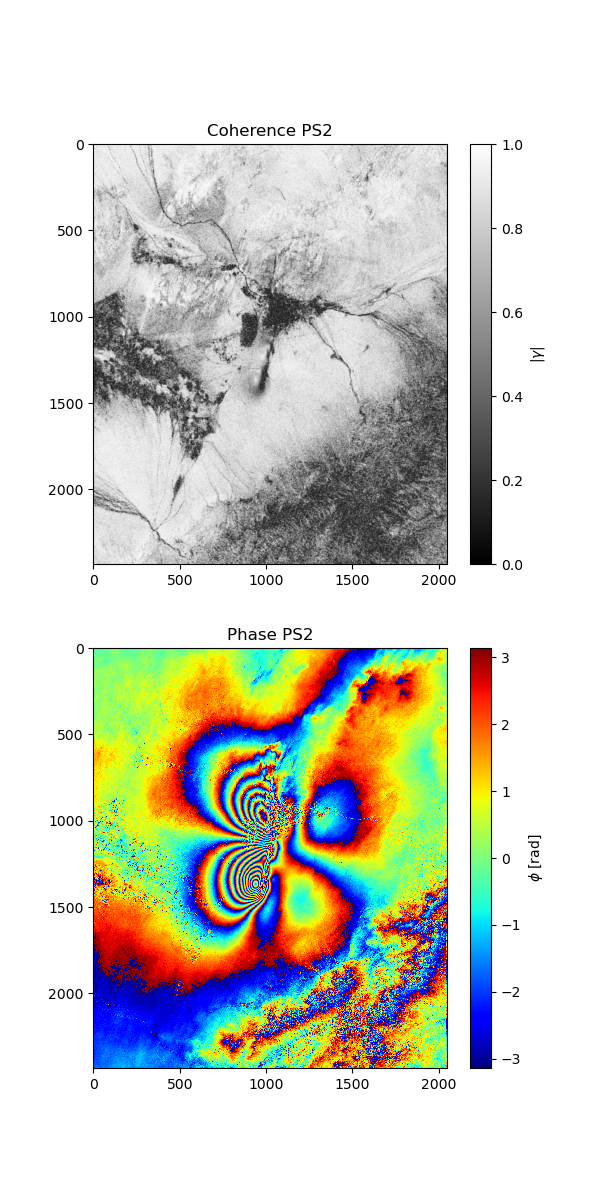

In [5]:
# Calculate coherence between primary and secondary2 (Baseline 0.1m)
coherence_ps2 = calculate_covariance(img_p, img_s2_fe, looksr, looksa)
amp_s2 = np.sqrt(np.abs(calculate_covariance(img_s2_fe, img_s2_fe, looksr, looksa)))
coherence_ps2 = coherence_ps2 / (amp_p*amp_s2)

#Display
plt.figure(figsize=(6,12))
plt.subplot(211)
plt.imshow(np.abs(coherence_ps2), vmin=0, vmax=1, cmap='gray')
cb = plt.colorbar()
cb.set_label(r'|$\gamma$|')
plt.title('Coherence PS2')
plt.subplot(212)
plt.imshow(np.angle(coherence_ps2), vmin=-np.pi, vmax=np.pi, cmap='jet', interpolation='none')
cb = plt.colorbar()
cb.set_label(r'$\phi$ [rad]')
plt.title('Phase PS2')


Text(0.5, 1.0, 'Phase PS2')

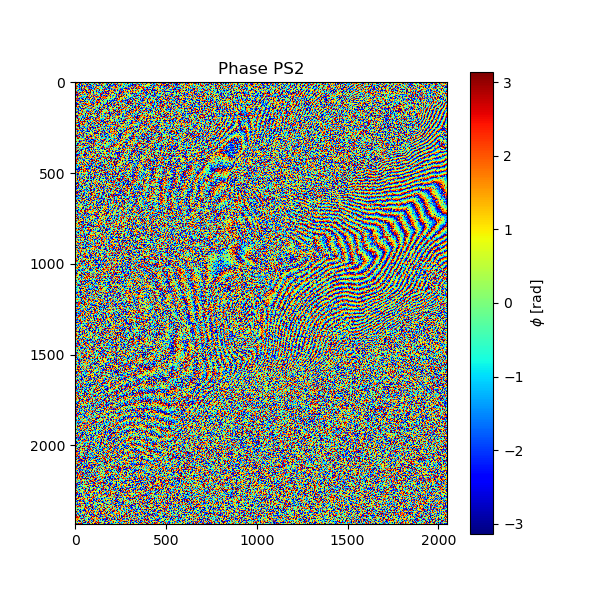

In [6]:
# Calculate coherence between primary and secondary1 (Baseline 520m)
coherence_ps1 = calculate_covariance(img_p, img_s1_fe, looksr, looksa)
amp_s1 = np.sqrt(np.abs(calculate_covariance(img_s1_fe, img_s1_fe, looksr, looksa)))
coherence_ps1 = coherence_ps1 / (amp_p*amp_s1)

# Display
plt.figure(figsize=(6,6))
plt.imshow(np.angle(coherence_ps1), vmin=-np.pi, vmax=np.pi, cmap='jet', interpolation='none')
cb = plt.colorbar()
cb.set_label(r'$\phi$ [rad]')
plt.title('Phase PS2')

**Removal of fringes due to topography**

Text(0.5, 1.0, 'DEM')

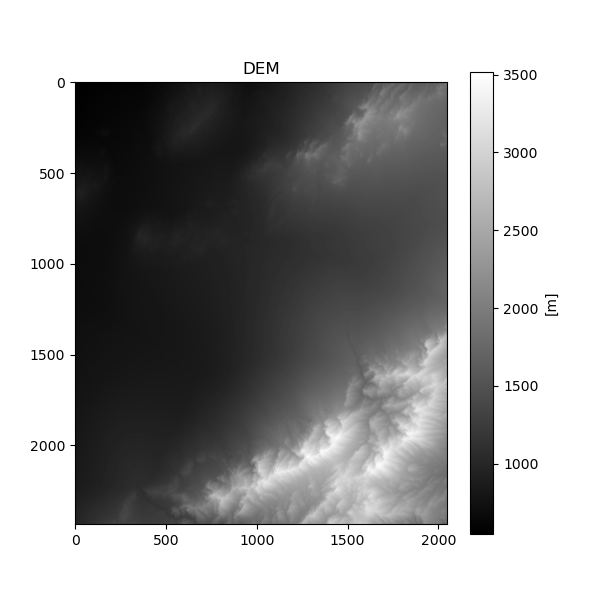

In [7]:
# Load DEM
dem = np.load(path + 'slantdem_envisat.npy')

# Display
plt.figure(figsize=(6,6))
plt.imshow(dem, cmap='gray')
cb = plt.colorbar()
cb.set_label('[m]')
plt.title('DEM')

Text(0.5, 1.0, 'Phase PS2 after FE + DEM correction')

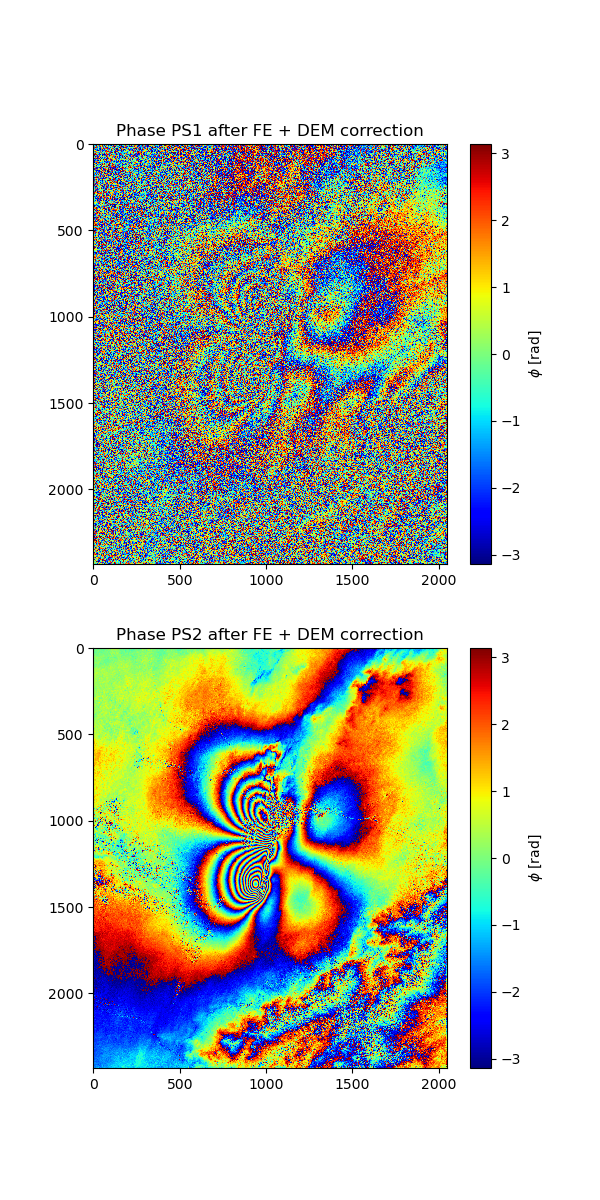

In [8]:
# Mean height [m]
h_mean = 717

# Load kz
kz_s1 = np.load(path + 'kz1_envisat.npy')
kz_s2 = np.load(path + 'kz2_envisat.npy')

# Compensate flat-earth and DEM phase
phase_full_s1 = np.angle(img_p*np.conj(img_s1))
phase_fe_dem_s1 = np.exp(1j*(phase_full_s1 - flat_phase_s1 - kz_s1*(dem-h_mean)))
phase_s1 = smooth(phase_fe_dem_s1, 5, phase=True)

phase_full_s2 = np.angle(img_p*np.conj(img_s2))
phase_fe_dem_s2 = np.exp(1j*(phase_full_s2 - flat_phase_s2 - kz_s2*(dem-h_mean)))
phase_s2 = smooth(phase_fe_dem_s2, 5, phase=True)

# Display
plt.figure(figsize=(6,12))
plt.subplot(211)
plt.imshow(np.angle(phase_s1), vmin=-np.pi, vmax=np.pi, cmap='jet', interpolation='none')
cb = plt.colorbar()
cb.set_label(r'$\phi$ [rad]')
plt.title('Phase PS1 after FE + DEM correction')
plt.subplot(212)
plt.imshow(np.angle(phase_s2), vmin=-np.pi, vmax=np.pi, cmap='jet', interpolation='none')
cb = plt.colorbar()
cb.set_label(r'$\phi$ [rad]')
plt.title('Phase PS2 after FE + DEM correction')

**Phase Filtering**

Text(0.5, 1.0, 'Phase PS2 after FE + DEM correction')

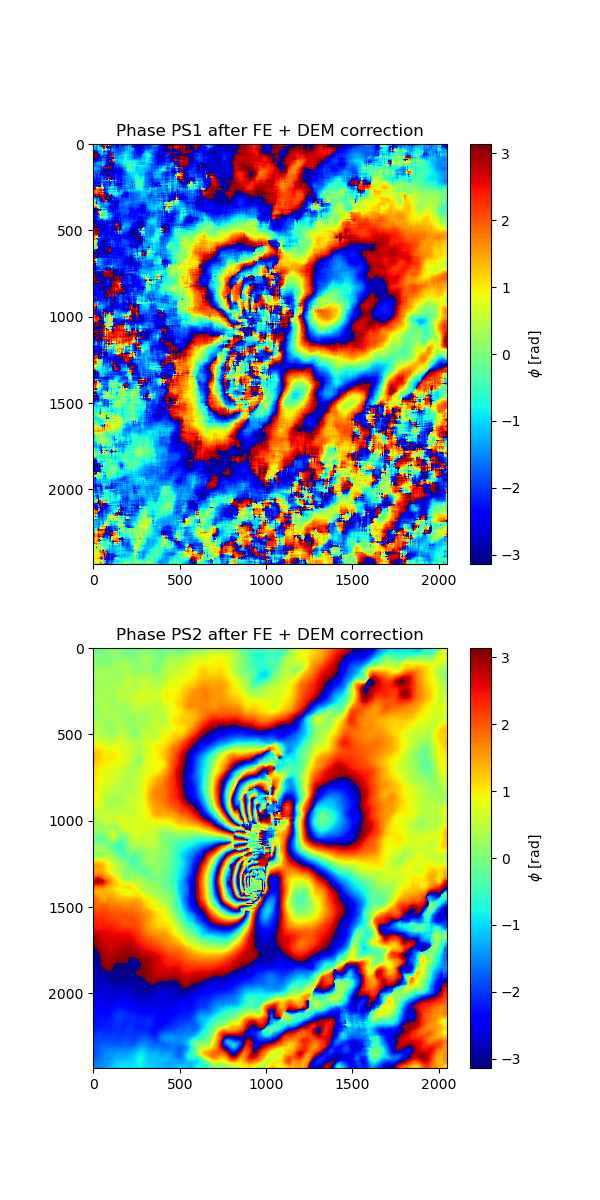

In [10]:
phase_s1 = smooth(phase_fe_dem_s1, 50, phase=True)
phase_s2 = smooth(phase_fe_dem_s2, 50, phase=True)

# Display
plt.figure(figsize=(6,12))
plt.subplot(211)
plt.imshow(np.angle(phase_s1), vmin=-np.pi, vmax=np.pi, cmap='jet', interpolation='none')
cb = plt.colorbar()
cb.set_label(r'$\phi$ [rad]')
plt.title('Phase PS1 after FE + DEM correction')
plt.subplot(212)
plt.imshow(np.angle(phase_s2), vmin=-np.pi, vmax=np.pi, cmap='jet', interpolation='none')
cb = plt.colorbar()
cb.set_label(r'$\phi$ [rad]')
plt.title('Phase PS2 after FE + DEM correction')